In [18]:
from __future__ import print_function
# !pip install torch
# !pip install torchvision
import torch
from torchvision import datasets, transforms
import sys
import timeit
#!pip install factor_analyzer
from factor_analyzer import Rotator # May need to be installed; see https://pypi.org/project/factor-analyzer/
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from pylab import *

from utils import *
from helper_layers import *
from base_class import *
from mirt_vae import *
from read_data import *

# Re-import some packages to reload functions without needing to restart the kernel. jupyter notebook doesn't update the files in the same kernel
import sys, importlib
importlib.reload(sys.modules["utils"])
importlib.reload(sys.modules["helper_layers"])
importlib.reload(sys.modules["base_class"])
importlib.reload(sys.modules["mirt_vae"])
importlib.reload(sys.modules["read_data"])

from utils import *
from helper_layers import *
from base_class import *
from mirt_vae import *
from read_data import *

# Suppress scientific notation.
np.set_printoptions(suppress = True)

# Print full arrays.
np.set_printoptions(threshold = sys.maxsize)

# If CUDA is available, use it.
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {"num_workers" : 1, "pin_memory" : True} if cuda else {}

# Set log interval.
ipip_log_interval = 200

In [19]:
ipip_filename = "ipip_ffm_recoded_int.csv"
# Python iterable over a dataset, loads data from dataset input, 
# yields batched samples instead of individual samples, 
# shuffled sampler automatically constructed

# Full data set.
ipip_loader = torch.utils.data.DataLoader(
    csv_dataset(csv_file = ipip_filename,
                which_split = "full",
                csv_header = None,
                categories = np.tile(np.array([[1,2,3,4,5]]), (50, 1))),
    batch_size = 32, shuffle = True, **kwargs)

# Test data set.
ipip_test_loader = torch.utils.data.DataLoader(
    csv_dataset(csv_file = ipip_filename,
                which_split = "test-only",
                test_size = 0.025,
                
                csv_header = None,
                categories = np.tile(np.array([[1,2,3,4,5]]), (50, 1))),
    batch_size = 32, shuffle = True, **kwargs)

# Train data set.
ipip_train_loader = torch.utils.data.DataLoader(
    csv_dataset(csv_file = ipip_filename,
                which_split = "train-only",
                test_size = 0.025,
               
                csv_header = None,
                categories = np.tile(np.array([[1,2,3,4,5]]), (50, 1))),
    batch_size = 32, shuffle = True, **kwargs)

/Users/sharahe/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
/Users/sharahe/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':
/Users/sharahe/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
/Users/sharahe/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.catego


Starting fitting for P = 1
Model fitted, run time = 90.22 seconds

Computing approx. LL
Approx. LL computed in 4.3 seconds
Approx. LL stored, computed in 4.3 seconds

Starting fitting for P = 2
Model fitted, run time = 72.53 seconds

Computing approx. LL
Approx. LL computed in 4.6 seconds
Approx. LL stored, computed in 4.6 seconds

Starting fitting for P = 5
Model fitted, run time = 92.81 seconds

Computing approx. LL
Approx. LL computed in 3.94 seconds
Approx. LL stored, computed in 3.94 seconds

Starting fitting for P = 7
Model fitted, run time = 78.0 seconds

Computing approx. LL
Approx. LL computed in 4.07 seconds
Approx. LL stored, computed in 4.07 seconds


Latent dimension = 1 Approx. LL = -876751.04
Latent dimension = 2 Approx. LL = -847538.67
Latent dimension = 5 Approx. LL = -792280.77
Latent dimension = 7 Approx. LL = -786566.7


/Users/sharahe/Desktop/School/GatesLab/deep_exploratory_ifa/mirt_vae.py:428: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


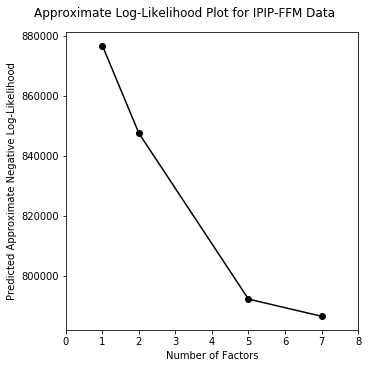

In [7]:
# Extract log likelihood
log_likelihoods = screeplot(latent_dims = [1, 2, 5, 7],
                            n_cats = [5] * 50,
                            device = device,
                            ipip_train_loader = ipip_train_loader, 
                            ipip_test_loader = ipip_test_loader,
                            iw_samples_bic = 100,
                            title = "Approximate Log-Likelihood Plot for IPIP-FFM Data")


In [20]:

# Set random seeds.
seed = 1
# sets the seed for generating random numbers
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize model.
print("\nStarting fitting")

# starting the timer to count how much time is taken to run code
start = timeit.default_timer()
ipip_vae = MIRTVAEClass(input_dim = 250, # number of columns in binarized data matrix
                        inference_model_dims = [130], # list of neural network hidden layer sizes
                        latent_dim = 5, # refers to the output num of dimensions after encoding
                        n_cats = [5] * 50, # list of number of categories for each item (because it's a range 1-5)
                        learning_rate = 5e-3, # rate at which the model learns 
                        device = device,
                        log_interval = ipip_log_interval,
                        steps_anneal = 1000)

"""
Fit model.
Note: iw_samples can be increased to improve the approximation to the MMLE.
As described in the paper, iw_samples = 5 seems to perform well in practice.
"""
ipip_vae.run_training(ipip_loader, ipip_test_loader, iw_samples = 5) # run training on the full dataloader and test loader

# stopping timer
stop = timeit.default_timer()
run_time = stop - start
print("Fitting completed in", round(run_time, 2), "seconds")

# Extract estimated loadings and intercepts.
# loadings = ipip_vae.model.loadings.weight.data.numpy()
# intercepts = ipip_vae.model.intercepts.bias.data.numpy()
loadings = ipip_vae.get_unrotated_loadings()
intercepts = ipip_vae.get_intercepts()
"""
Rotate loadings and extract factor correlations.
Note: In the paper I used geomin rotation, whereas here I use oblimin.
"""
rot_loadings, cor_mat = get_rotated_loadings(loadings = loadings, method = "oblimin")

"""
Compute approximate log-likelihood.
Note: This computation can be sped up or slowed down by decreasing or increasing
iw_samples, respectively. In the paper, I set iw_samples = 5000. 
"""

ll = ipip_vae.bic(ipip_test_loader,
                  iw_samples = 100)[1]



Starting fitting
Fitting completed in 67.08 seconds
Rotated loadings computed in 0.01 seconds

Computing approx. LL
Approx. LL computed in 4.01 seconds


In [21]:
print(cor_mat)

[[ 1.          0.17622388  0.04514159 -0.11101834 -0.00432812]
 [ 0.17622388  1.          0.19527661 -0.25311621 -0.08032342]
 [ 0.04514159  0.19527661  1.          0.0348355  -0.24435531]
 [-0.11101834 -0.25311621  0.0348355   1.          0.1187916 ]
 [-0.00432812 -0.08032342 -0.24435531  0.1187916   1.        ]]


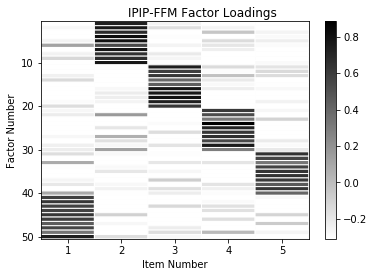

In [24]:
loadings_heatmap(rot_loadings, loadings, x_label = "Item Number", y_label = "Factor Number", title = "IPIP-FFM Factor Loadings")